In [2]:
import os
import pandas as pd
from typing import List, Tuple

def load_pdfs_from_folder(folder_path: str) -> List[Tuple[str, bytes]]:
    files = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(".pdf"):
            full_path = os.path.join(folder_path, file)
            with open(full_path, "rb") as f:
                files.append((file, f.read()))
    return files


pdf_files = load_pdfs_from_folder("../sampleData")
len(pdf_files)


5

In [3]:
from typing import Dict

GP_MAP: Dict[str, float] = {
    "A+": 4.0, "A": 4.0, "A-": 3.7,
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0,
    "E": 0.0, "F": 0.0,
}


In [4]:
CREDITS: Dict[str, int] = {
    "IT2020": 4,
    "IT2030": 4,
    "IT2040": 4,
    "IT2050": 4,
    "IT2060": 4,
    "IT2010": 4,
    "IT2070": 4,
    "IT2080": 4,
    "IT2090": 2,
    "IT2110": 3,
}


In [5]:

import re
from typing import Optional 

MODULE_PATTERN = re.compile(r"(IT\d{3,4})", re.IGNORECASE)
GRADE_PATTERN = re.compile(r"^[A-F][+-]?$|^[0-9]{1,3}(?:\.[0-9]+)?$", re.IGNORECASE)
REG_PATTERN = re.compile(r"^IT\w*", re.IGNORECASE)



def _extract_module_code_from_name(name: str) -> Optional[str]:
    m = MODULE_PATTERN.search(name)
    return m.group(1).upper() if m else None


def _grade_to_gp(grade: Optional[str]) -> Optional[float]:
    if not isinstance(grade, str):
        return None
    return GP_MAP.get(grade.strip().upper())


In [6]:
from collections import defaultdict

import pdfplumber


def parse_result_pdfs(files: List[Tuple[str, bytes]]) -> pd.DataFrame:
    student_results = defaultdict(dict)
    found_modules = set()

    for filename, file_bytes in files:
        module_code = _extract_module_code_from_name(filename)

        with pdfplumber.open(io.BytesIO(file_bytes)) as pdf:
            for page in pdf.pages:
                table = page.extract_table()
                if not table or len(table) <= 1:
                    continue

                for row in table[1:]:
                    reg_no = None
                    for cell in row:
                        if isinstance(cell, str) and REG_PATTERN.match(cell.strip()):
                            reg_no = cell.strip()
                            break

                    if not reg_no:
                        continue

                    grade = None
                    for cell in reversed(row):
                        if isinstance(cell, str) and GRADE_PATTERN.match(cell.strip()):
                            grade = cell.strip()
                            break

                    if module_code and grade:
                        found_modules.add(module_code)
                        student_results[reg_no][module_code] = grade

    rows = []
    for reg_no, mods in student_results.items():
        row = {"Registration No": reg_no}
        for mod in found_modules:
            row[mod] = mods.get(mod)
        rows.append(row)

    return pd.DataFrame(rows)


In [9]:
import io
df = parse_result_pdfs(pdf_files)
df.head()


,Registration No,IT2070,IT2080,IT2110,IT2090,IT2010
0,IT 21 8313 86,E,A-,E,E,C
1,IT 22 0736 00,D,A-,E,C+,C+
2,IT 22 0755 12,C+,A-,C,A-,B-
3,IT 22 1305 70,E,F,E,E,E
4,IT 22 2054 38,A,A,A+,None,A-


In [10]:
def calculate_gpa(df: pd.DataFrame) -> pd.DataFrame:
    module_cols = [c for c in df.columns if c != "Registration No"]
    gpas = []

    for _, row in df.iterrows():
        total_points = 0
        total_credits = 0

        for mod in module_cols:
            gp = _grade_to_gp(row[mod])
            if gp is not None:
                cr = CREDITS.get(mod, 1)
                total_points += gp * cr
                total_credits += cr

        gpas.append(round(total_points / total_credits, 2))

    df["GPA"] = gpas
    return df


df = calculate_gpa(df)
df.head()


,Registration No,IT2070,IT2080,IT2110,IT2090,IT2010,GPA
0,IT 21 8313 86,E,A-,E,E,C,1.34
1,IT 22 0736 00,D,A-,E,C+,C+,1.92
2,IT 22 0755 12,C+,A-,C,A-,B-,2.84
3,IT 22 1305 70,E,F,E,E,E,0.00
4,IT 22 2054 38,A,A,A+,None,A-,3.92


In [11]:
def add_ranks(df: pd.DataFrame) -> pd.DataFrame:
    df["Rank"] = df["GPA"].rank(ascending=False, method="min").astype(int)
    df["Total Students"] = len(df)
    df["Percentile"] = ((1 - (df["Rank"] - 1) / len(df)) * 100).round(2)
    return df


df = add_ranks(df)
df.sort_values("Rank").head()


,Registration No,IT2070,IT2080,IT2110,IT2090,IT2010,GPA,Rank,Total Students,Percentile
1815,IT 23 6927 32,None,None,None,A,None,4.0,1,1920,100.0
86,IT 23 5419 48,A,A,A+,A,A,4.0,1,1920,100.0
939,IT 23 7147 48,A,A,A+,A,A,4.0,1,1920,100.0
497,IT 23 6216 88,A,A+,A+,None,A,4.0,1,1920,100.0
519,IT 23 6260 10,A,A,A+,A,A,4.0,1,1920,100.0


<Axes: >

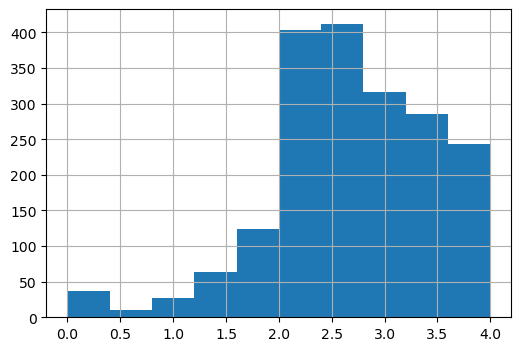

In [12]:
df["GPA"].hist(bins=10, figsize=(6,4))


<Axes: xlabel='Rank', ylabel='GPA'>

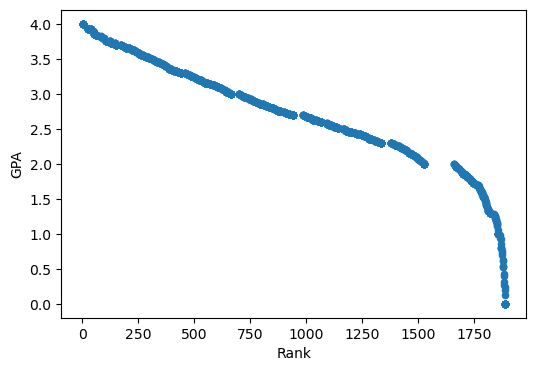

In [13]:
df.sort_values("Rank").plot(
    x="Rank", y="GPA", kind="scatter", figsize=(6,4)
)
